In [61]:
import os
import networkx as nx
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [62]:
def graph1_adjacency_matrix():
    return np.array([
        [0, 1, 1, 0, 0, 0, 1, 0, ],
        [1, 0, 0, 1, 0, 0, 0, 1, ],
        [1, 0, 0, 1, 1, 0, 0, 0, ],
        [0, 1, 1, 0, 0, 1, 0, 0, ],
        [0, 0, 1, 0, 0, 1, 1, 0, ],
        [0, 0, 0, 1, 1, 0, 0, 1, ],
        [1, 0, 0, 0, 1, 0, 0, 1, ],
        [0, 1, 0, 0, 0, 1, 1, 0, ],
    ])


In [63]:
def build_test_graph1():
    adj_mat = graph1_adjacency_matrix()
    N = len(adj_mat)

    G = nx.Graph()
    for i in range(N):
        G.add_node(str(i))

    for i in range(N):
        for j in range(N):
            if adj_mat[i][j] == 1:
                G.add_edge(str(i), str(j))
    return G

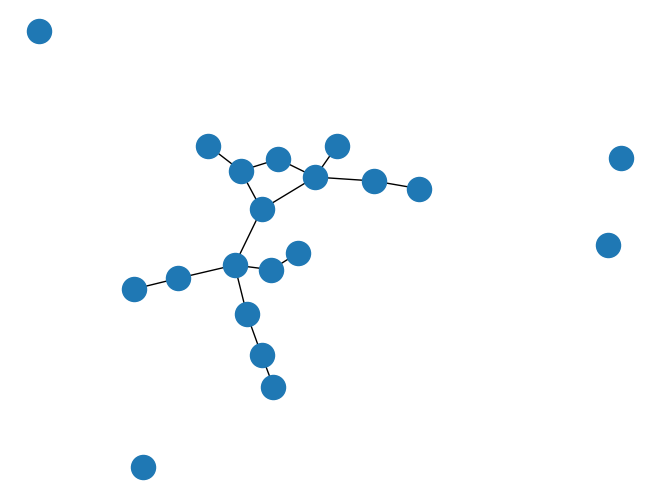

In [64]:
# G = build_test_graph1()
# G = nx.complete_graph(10)
# G = nx.graph_atlas(1000)
G = nx.gnp_random_graph(20, 0.075, seed = 3)

nx.draw(G)

In [65]:
def calc_W(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    W = np.zeros((n,n+m+m_c))
    for i in range(n):
        W[i][i] = 1
    j = n
    for edge in G.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    for edge in C.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    return W

def calc_b(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    b = np.array([-1/2 for i in range(n)])
    b_m = np.array([-1 for i in range(m+m_c)])
    return np.concatenate((b,b_m))

def calc_w(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    w = np.array([-1 for i in range(n)])
    w_n = np.array([n for i in range(m)])
    w_c = np.array([-1 for i in range(m_c)])
    return np.concatenate((w,w_n,w_c))

def build_network(G):
    C = nx.complement(G)
    W = calc_W(G, C)
    b = calc_b(G, C)
    w = calc_w(G, C)
    omega = np.array([random.random() for i in range(len(G.nodes()))])
    return (W,b,w, omega, C)


In [66]:
def train_network(G, epochs = 1000):
    (W,b,w, omega, C) = build_network(G)
    n = len(G.nodes())
    W_t = tf.constant(W.T, dtype = 'float32')
    b = tf.constant(b, dtype = 'float32')
    w_t = tf.constant(w.T, dtype = 'float32')
    omega = tf.Variable(omega, dtype = 'float32')

    e_n = tf.ones((n))

    h_d = -n*n/2
    # print("h_d="+str(h_d))
    optimizer=tf.optimizers.Adam(learning_rate=0.1)

    def network():
        h = tf.clip_by_value(omega, 0, 1)
        h = tf.math.multiply(e_n,h)
        h = tf.linalg.matvec(W_t,h)
        h = tf.add(h,b)
        h = tf.nn.relu(h)
        h = tf.tensordot(w_t,h, 1)
        return h

    def loss():
        h = network()
        return (h-h_d)*(h-h_d)

    for i in range(epochs):
        last_optimization = optimizer.minimize(loss, var_list=[omega])
    result_nodes = omega.numpy() > 1 
    result_cardinality = np.count_nonzero(result_nodes)
    print("Nodes count = {}".format(result_cardinality))    
    return omega
    

def draw_graph(G,omega):
    color_map = ['green' if node in MIS else 'blue' for node in G]        
    graph = nx.draw(G, node_color=color_map) # node lables

In [72]:
def draw_determenistic_result(G):
    MIS = nx.maximal_independent_set(G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    color_map = ['red' if node in MIS else 'blue' for node in G]        
    graph = nx.draw(G, node_color=color_map) # node lables

In [73]:
def draw_my_result(G, omega, threshold = 0.5):
    result_nodes = np.argwhere(omega.numpy() > threshold)
    print(result_nodes)
    print("Length = "+str(len(result_nodes)))
    color_map = ['green' if node in result_nodes else 'blue' for node in G]        
    graph = nx.draw(G, node_color=color_map) # node lables

In [77]:
omega = train_network(G)

Nodes count = 12


[11, 7, 16, 5, 2, 14, 6, 1, 18, 10, 3, 19]
Length = 12


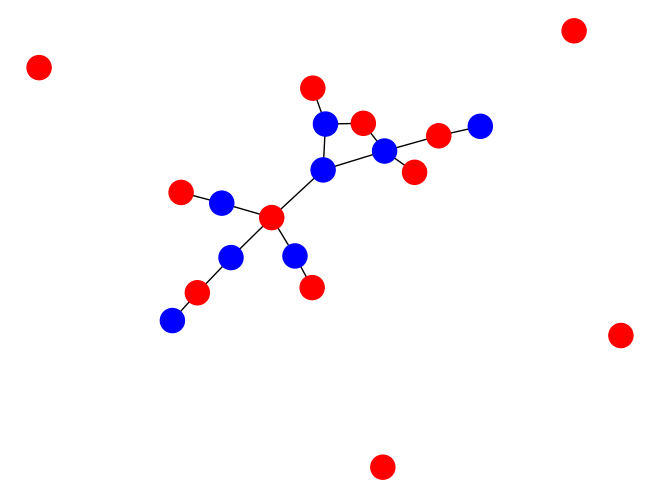

In [78]:
draw_determenistic_result(G)

[[ 1]
 [ 2]
 [ 3]
 [ 6]
 [10]
 [11]
 [12]
 [13]
 [14]
 [17]
 [18]
 [19]]
Length = 12


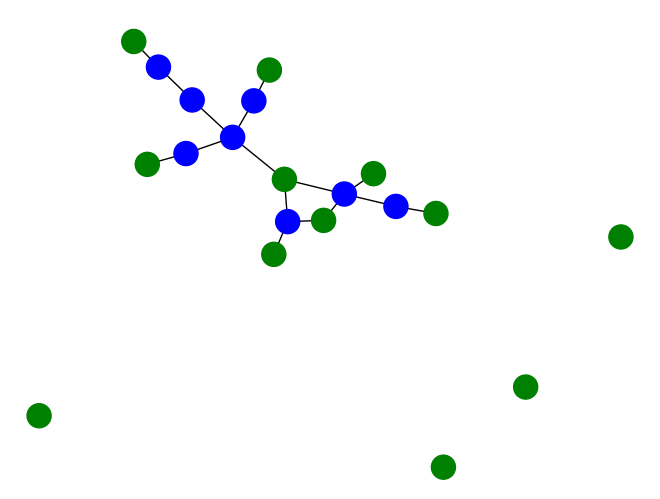

In [79]:
draw_my_result(G, omega)